<a href="https://colab.research.google.com/github/N125-ui/GOOGLE-COLAB/blob/main/PROJECT_PART_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving combined_by_state_year_month.csv to combined_by_state_year_month.csv


In [ ]:
# Load the dataset
data = pd.read_csv('combined_by_state_year_month.csv')

data.describe()

,Year,Total_Accidents.1
count,1684.000000,1684.000000
mean,2020.460808,1.781473
std,1.709158,0.944566
min,2018.000000,1.000000
25%,2019.000000,1.000000
50%,2020.000000,2.000000
75%,2022.000000,2.000000
max,2023.000000,6.000000


In [ ]:
print(data.columns)

Index(['State Name', 'Year', 'Month', 'timestamp', 'Day of Week',
       'Time _of _Day', 'Accident_Severity', 'Number of Vehicles Involved',
       'Vehicle Type Involved', 'Number of Casualties', 'Number of Fatalities',
       'Weather Conditions', 'Road Type', 'Road Condition',
       'Lighting Conditions', 'Traffic Control Presence', 'Speed Limit (km/h)',
       'Driver Age', 'Driver Gender', 'Driver License Status',
       'Alcohol Involvement', 'Accident Location Details', 'Month_num',
       'Weekday_num', 'day', 'Time_in_seconds', 'Total_Accidents',
       'Total_Accidents.1'],
      dtype='object')


In [ ]:
data.isnull().sum().sort_values(ascending=False)

,0
State Name,0
Year,0
Month,0
timestamp,0
Day of Week,0
Time _of _Day,0
Accident_Severity,0
Number of Vehicles Involved,0
Vehicle Type Involved,0
Number of Casualties,0


In [ ]:
data['Driver License Status'] = data['Driver License Status'].fillna('Unknown')

data['Traffic Control Presence'] = data['Traffic Control Presence'].fillna('Unknown')

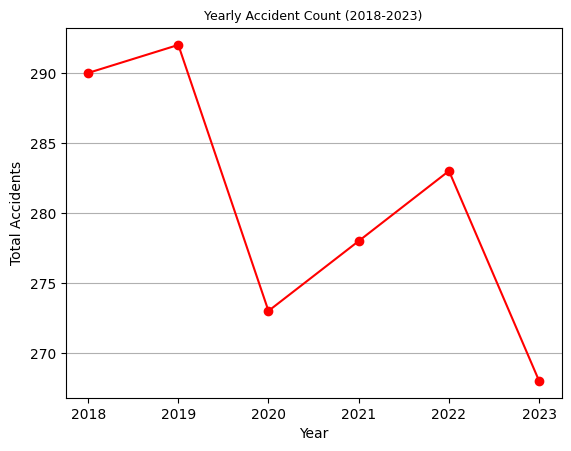

In [ ]:
data['Year'] = pd.to_datetime(data['Year'], format='%Y')
yearly_accident = data.groupby('Year')['Total_Accidents'].count()

plt.plot(yearly_accident.index, yearly_accident.values, marker="o", linestyle="-", color='red')
plt.xlabel('Year')
plt.ylabel('Total Accidents')
plt.title('Yearly Accident Count (2018-2023)', fontsize=9)
plt.grid(axis='y')
plt.show()

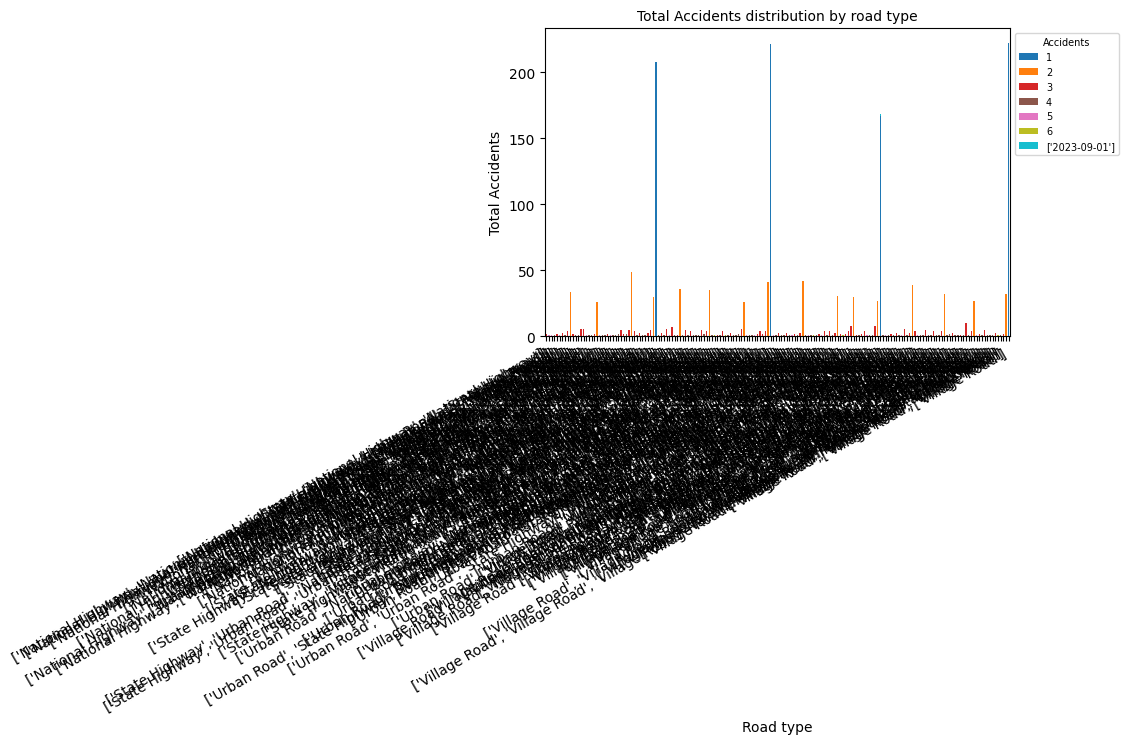

In [ ]:
# Create cross-tab of Accident_Severity vs state
cross_tab = pd.crosstab(data['Road Type'], data['Total_Accidents'])

# Plot stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(6,4), colormap='tab10')
plt.title('Total Accidents distribution by road type',fontsize=10)
plt.xlabel('Road type')
plt.ylabel('Total Accidents')
plt.xticks(rotation=30, ha='right')
plt.legend(title='Accidents',fontsize=7, title_fontsize=7, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [ ]:
# Convert 'Year' to datetime format
data['Year'] = pd.to_datetime(data['Year'], errors='coerce')

# Function to safely extract the first numeric value from a list-like string
def extract_first_numeric(value):
    try:
        # Attempt to convert the string representation of a list/single value
        # into an actual list or value and take the first element
        processed_value = eval(str(value))
        if isinstance(processed_value, list) and processed_value:
            # Convert the first element to numeric, coercing errors
            return pd.to_numeric(processed_value[0], errors='coerce')
        elif pd.notna(processed_value):
            # If it's not a list but not NaN, try converting directly
             return pd.to_numeric(processed_value, errors='coerce')
        else:
            return np.nan # Return NaN for empty lists or other issues
    except:
        return np.nan # Return NaN for any errors during processing

# Apply the function to the relevant columns
data['Speed Limit (km/h)'] = data['Speed Limit (km/h)'].apply(extract_first_numeric)
data['Driver Age'] = data['Driver Age'].apply(extract_first_numeric)

# Handle 'Accident Location Details' separately using MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Convert string representation of lists to actual lists, handling errors
data['Accident Location Details'] = data['Accident Location Details'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
data['Accident Location Details'] = data['Accident Location Details'].apply(lambda x: [item for item in x if isinstance(item, str)]) # Ensure elements within list are strings

mlb = MultiLabelBinarizer()
# Handle potential non-list values or errors during binarization
try:
    accident_details_encoded = mlb.fit_transform(data['Accident Location Details'])
    accident_details_df = pd.DataFrame(accident_details_encoded, columns=[f"AccidentLocation_{c}" for c in mlb.classes_], index=data.index)
except ValueError as e:
    print(f"Error during MultiLabelBinarization: {e}")
    # Create an empty DataFrame or handle the error as appropriate for your analysis
    accident_details_df = pd.DataFrame(index=data.index)


# Encode other categorical features
other_categorical_features = ['State Name', 'Month', 'Weather Conditions', 'Road Type', 'Road Condition',
                              'Lighting Conditions', 'Traffic Control Presence',
                              'Driver Gender', 'Driver License Status', 'Alcohol Involvement',
                              'Accident_Severity']
data_other_categorical_encoded = pd.get_dummies(data[other_categorical_features], prefix=other_categorical_features, drop_first=True)


# Select numerical features
numerical_features = ['Speed Limit (km/h)', 'Driver Age']
data_numerical = data[numerical_features]

# Extract year as numerical
year_column = data['Year'].dt.year.to_frame(name='Year')


# Concatenate all features
data_encoded = pd.concat([data_numerical, data_other_categorical_encoded, accident_details_df, year_column], axis=1)

# Define features and target
X = data_encoded
y = data['Total_Accidents']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Define features and target again to ensure correct dimensions for classification models
X = data_encoded

# Convert 'Total_Accidents' to numeric, coercing errors to NaN, and drop rows with NaN
data['Total_Accidents'] = pd.to_numeric(data['Total_Accidents'], errors='coerce')
# Align X and y after dropping rows with NaN in 'Total_Accidents'
data_aligned = data.dropna(subset=['Total_Accidents'])
X_aligned = X.loc[data_aligned.index]
y_aligned = data_aligned['Total_Accidents'].astype(int) # Convert to int here


X_train, X_test, y_train, y_test = train_test_split(X_aligned, y_aligned, test_size=0.2, random_state=42)

# Adjust y_train and y_test to be zero-indexed for XGBoost
y_train = y_train - 1
y_test = y_test - 1

Classification Report (Random forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       106
           2       0.92      1.00      0.96        47
           3       0.69      1.00      0.82         9
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         1

    accuracy                           0.98       337
   macro avg       0.60      0.67      0.63       337
weighted avg       0.96      0.98      0.97       337



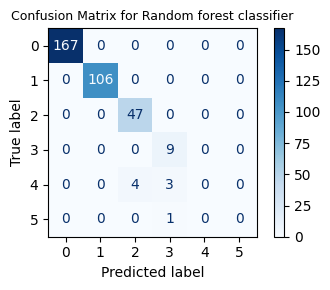

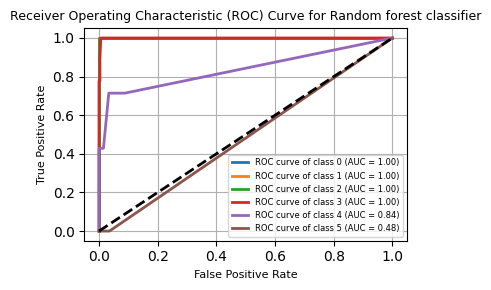

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import numpy as np # Import numpy

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

print("Classification Report (Random forest):")
print(classification_report(y_test, y_pred_rf))

#Plot confusion matrix

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for Random forest classifier', fontsize=9) # Removed severity labels as they might not match classes
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Binarize the output for ROC curve
# Determine the unique classes present in the test set
unique_classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=unique_classes) # Corrected this line
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_score = model_rf.predict_proba(X_test)

plt.figure(figsize=(4, 3))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {unique_classes[i]} (AUC = {roc_auc[i]:0.2f})') # Use unique_classes for labels

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('Receiver Operating Characteristic (ROC) Curve for Random forest classifier', fontsize=9)
plt.legend(loc="lower right", fontsize=6)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
unique_classes

array([0, 1, 2, 3, 4, 5])

Classification Report (Logistic regression):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       106
           2       0.80      1.00      0.89        47
           3       1.00      0.56      0.71         9
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         1

    accuracy                           0.96       337
   macro avg       0.63      0.59      0.60       337
weighted avg       0.95      0.96      0.95       337


Confusion Matrix:
[[167   0   0   0   0   0]
 [  0 106   0   0   0   0]
 [  0   0  47   0   0   0]
 [  0   0   4   5   0   0]
 [  0   0   7   0   0   0]
 [  0   0   1   0   0   0]]


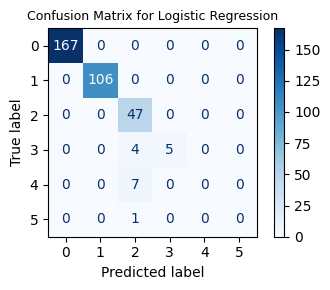

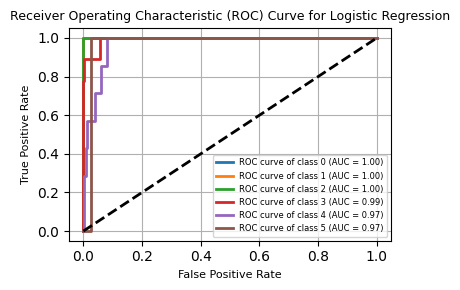

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

model_log = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
model_log.fit(X_train, y_train)
y_pred = model_log.predict(X_test)

print("Classification Report (Logistic regression):")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_log.classes_)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for Logistic Regression', fontsize=9)
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Binarize the output for ROC curve
unique_classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_score = model_log.predict_proba(X_test)

plt.figure(figsize=(4, 3))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {unique_classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression', fontsize=9)
plt.legend(loc="lower right", fontsize=6)
plt.grid(True)
plt.tight_layout()
plt.show()

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.50      1.00      0.66       167
           1       0.00      0.00      0.00       106
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         1

    accuracy                           0.50       337
   macro avg       0.08      0.17      0.11       337
weighted avg       0.25      0.50      0.33       337


Confusion Matrix:
[[167   0   0   0   0   0]
 [106   0   0   0   0   0]
 [ 47   0   0   0   0   0]
 [  9   0   0   0   0   0]
 [  7   0   0   0   0   0]
 [  1   0   0   0   0   0]]


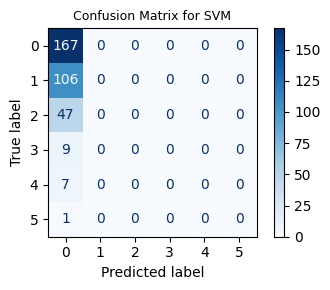

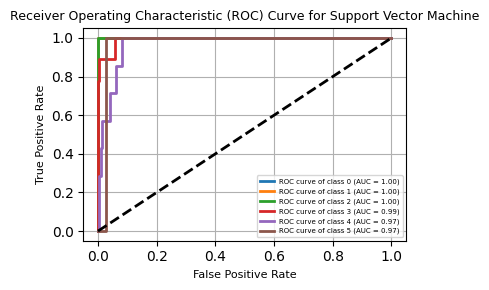

In [ ]:
# SVM

from sklearn.svm import SVC
model_svm = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_test)

print("Classification Report (SVM):")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_svm.classes_)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for SVM', fontsize=9)
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Binarize the output for ROC curve
unique_classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_score = model_log.predict_proba(X_test)

plt.figure(figsize=(4, 3))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('Receiver Operating Characteristic (ROC) Curve for Support Vector Machine', fontsize=9)
plt.legend(loc="lower right", fontsize=5)
plt.grid(True)
plt.tight_layout()
plt.show()

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       106
           2       0.89      1.00      0.94        47
           3       0.73      0.89      0.80         9
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         1

    accuracy                           0.97       337
   macro avg       0.60      0.65      0.62       337
weighted avg       0.95      0.97      0.96       337


Confusion Matrix:
[[167   0   0   0   0   0]
 [  0 106   0   0   0   0]
 [  0   0  47   0   0   0]
 [  0   0   1   8   0   0]
 [  0   0   5   2   0   0]
 [  0   0   0   1   0   0]]


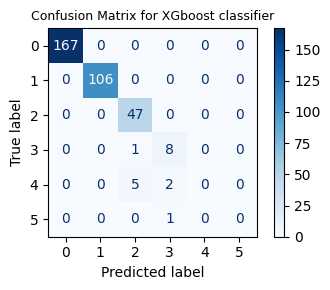

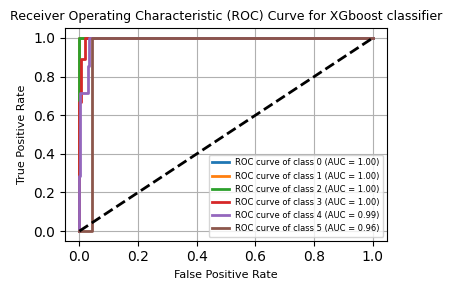

In [ ]:
# XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Adjust y_train and y_test to be integers for XGBoost
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Clean up feature names
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]


model_xgb = XGBClassifier(objective='multi:softmax', num_class=6, eval_metric='mlogloss', use_label_encoder='False', random_state=42)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(4, 3))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix for XGboost classifier', fontsize=9)
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Binarize the output for ROC curve
unique_classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_score = model_xgb.predict_proba(X_test)

plt.figure(figsize=(4, 3))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {unique_classes[i]} (AUC = {roc_auc[i]:0.2f})') # Use unique_classes for labels

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('Receiver Operating Characteristic (ROC) Curve for XGboost classifier', fontsize=9)
plt.legend(loc="lower right", fontsize=6)
plt.grid(True)
plt.tight_layout()
plt.show()

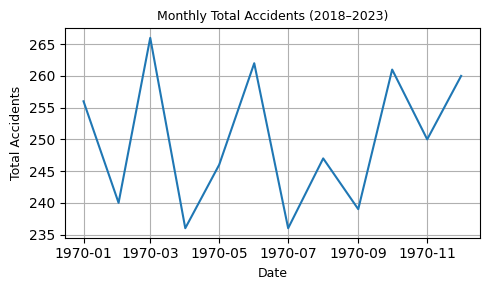

ValueError: x must have 2 complete cycles requires 24 observations. x only has 12 observation(s)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Prepare the data for time series analysis
data['Year'] = pd.to_datetime(data['Year'], format='%Y') # Convert 'Year' back to datetime
data['YearMonth'] = pd.to_datetime(data['Year'].dt.year.astype(str) + '-' + data['Month'], format='%Y-%B')
monthly_total_accidents = data.groupby('YearMonth')['Total_Accidents'].sum()


# 1. Time Series Plot
plt.figure(figsize=(5, 3))
sns.lineplot(x=monthly_total_accidents.index, y=monthly_total_accidents.values)
plt.title('Monthly Total Accidents (2018–2023)', fontsize=9)
plt.xlabel('Date', fontsize=9)
plt.ylabel('Total Accidents', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonal Decomposition
decomposition = seasonal_decompose(monthly_total_accidents, model='additive', period=12)
decomposition.plot()
plt.figure(figsize=(5,3))
plt.tight_layout()
plt.show()

ADF Statistic: -8.677006511154104
p-value: 4.3885571225716113e-14
Used lags: 0
Number of observations: 71
Critical Values:
   1%: -3.526004646825607
   5%: -2.9032002348069774
   10%: -2.5889948363419957
Series is stationary (reject H0)


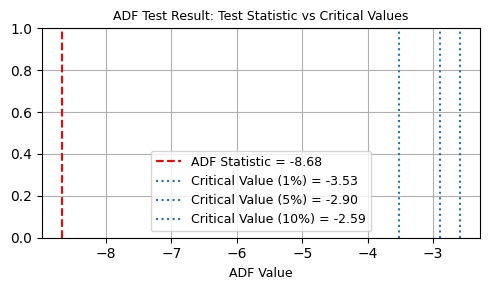

In [ ]:
# Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(monthly_total_accidents)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used lags:", adf_result[2])
print("Number of observations:", adf_result[3])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

if adf_result[1] < 0.05:
    print("Series is stationary (reject H0)")
else:
    print("Series is non-stationary (fail to reject H0)")

# Extract values from ADF result
adf_stat = adf_result[0]
p_value = adf_result[1]
crit_vals = adf_result[4]

# Plot ADF Test Statistic vs. Critical Values
plt.figure(figsize=(5, 3))
plt.axvline(x=adf_stat, color='red', linestyle='--', label=f'ADF Statistic = {adf_stat:.2f}')
for level, value in crit_vals.items():
    plt.axvline(x=value, linestyle=':', label=f'Critical Value ({level}) = {value:.2f}')

plt.title('ADF Test Result: Test Statistic vs Critical Values', fontsize=9)
plt.xlabel('ADF Value', fontsize=9)
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

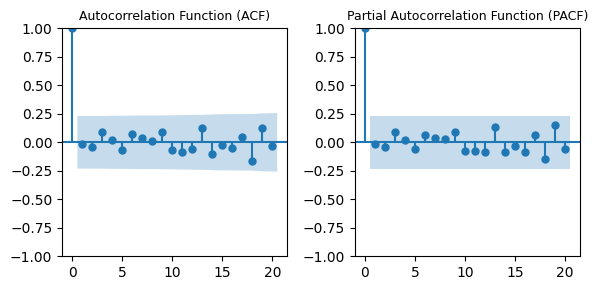

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(6, 3))

# ACF plot
plt.subplot(1,2,1)
plot_acf(monthly_total_accidents, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)', fontsize=9)

# PACF plot
plt.subplot(1,2,2)
plot_pacf(monthly_total_accidents, lags=20, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)', fontsize=9)

plt.tight_layout()
plt.show()

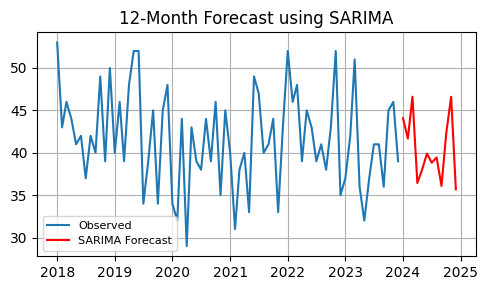

2024-01-01    44.080988
2024-02-01    41.678116
2024-03-01    46.611796
2024-04-01    36.439952
2024-05-01    38.007884
2024-06-01    39.906138
2024-07-01    38.830780
2024-08-01    39.443897
2024-09-01    36.086997
2024-10-01    42.286218
2024-11-01    46.599934
2024-12-01    35.697671
Freq: MS, Name: predicted_mean, dtype: float64
SARIMA RMSE: 3.415633727160698
SARIMA MAE: 1.622072085436185


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Fit SARIMA model
model = SARIMAX(monthly_total_accidents,
                order=(0, 1, 0),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

# Forecast next 12 months
forecast = results.forecast(steps=12)

# Plot
plt.figure(figsize=(5, 3))
plt.plot(monthly_total_accidents, label='Observed')
plt.plot(forecast.index, forecast, label='SARIMA Forecast', color='red')
plt.title('12-Month Forecast using SARIMA')
plt.legend(fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecast
print(forecast)

train = monthly_total_accidents[:'2022-12-01']
test = monthly_total_accidents['2023-01-01':]

from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = np.sqrt(mean_squared_error(test, forecast))
print("SARIMA RMSE:", rmse)
mae = np.sqrt(mean_absolute_error(test, forecast))
print("SARIMA MAE:", mae)

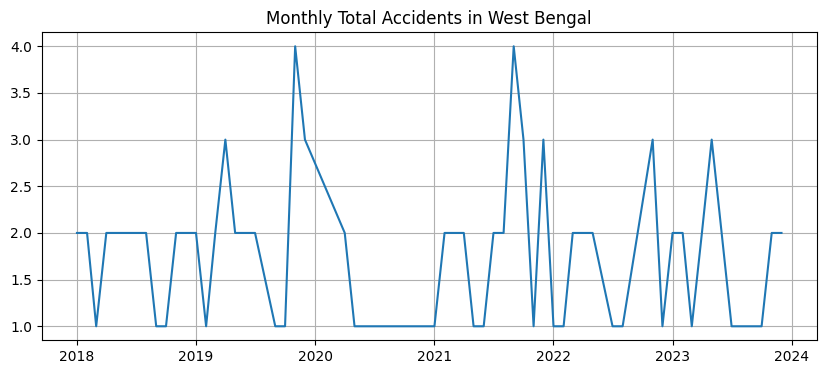

ADF Statistic: -6.324555320336761
p-value: 3.008602679294556e-08
Critical Value (1%): -3.562878534649522
Critical Value (5%): -2.918973284023669
Critical Value (10%): -2.597393446745562
Series is stationary


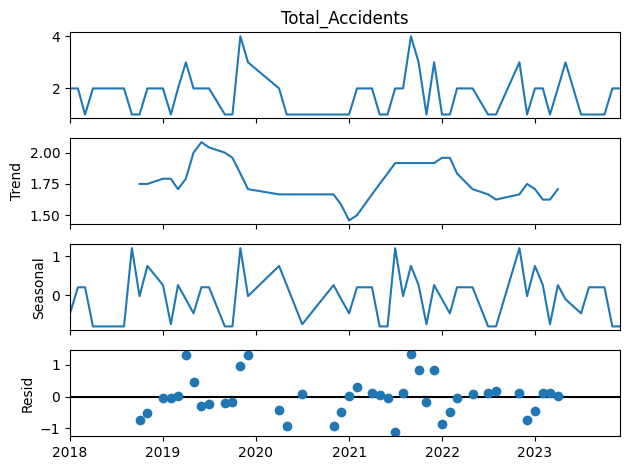

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


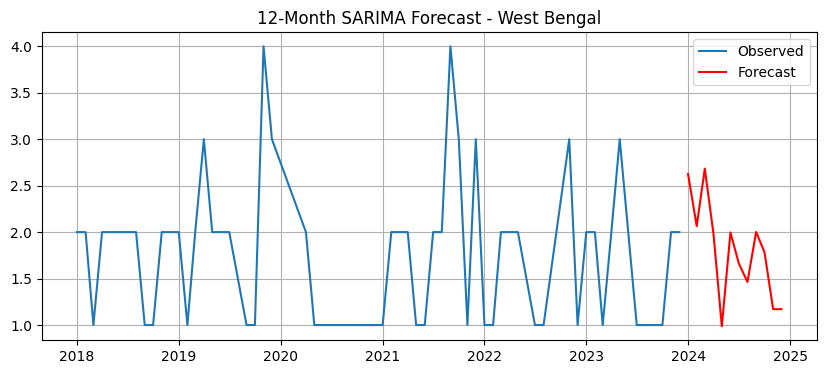

2024-01-01    2.625664
2024-02-01    2.064678
2024-03-01    2.682873
2024-04-01    1.986518
2024-05-01    0.986606
2024-06-01    1.996564
2024-07-01    1.662770
2024-08-01    1.463515
2024-09-01    2.001423
2024-10-01    1.784624
2024-11-01    1.170901
2024-12-01    1.170904
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming your DataFrame is called data and 'Year' and 'Month' columns are present

# Extract West Bengal time series
west_bengal_series = data[data['State Name'] == 'West Bengal'].copy()
west_bengal_series['Date'] = pd.to_datetime(west_bengal_series['Month'] + ' ' + west_bengal_series['Year'].dt.year.astype(str), format='%B %Y')
wb_ts = west_bengal_series.groupby('Date')['Total_Accidents'].sum().sort_index()

# Plot time series
plt.figure(figsize=(10, 4))
plt.plot(wb_ts)
plt.title("Monthly Total Accidents in West Bengal")
plt.grid(True)
plt.show()

# ADF Test
adf_result = adfuller(wb_ts)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")
if adf_result[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is non-stationary")

# Seasonal Decomposition (requires enough data)
if len(wb_ts) >= 24:
    decomposition = seasonal_decompose(wb_ts, model='additive', period=12)
    decomposition.plot()
    plt.tight_layout()
    plt.show()

# Fit SARIMA (adjust params if needed)
model = SARIMAX(wb_ts, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

# Forecast 12 months
forecast = results.forecast(steps=12)

# Plot

# Create correct datetime index for forecast
last_date = wb_ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(), periods=12, freq='MS')
forecast.index = forecast_index

plt.figure(figsize=(10, 4))
plt.plot(wb_ts, label="Observed")
plt.plot(forecast.index, forecast, color='red', label="Forecast")
plt.title("12-Month SARIMA Forecast - West Bengal")
plt.legend()
plt.grid(True)
plt.show()


 # Print forecasted values
print(forecast)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2875
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2807 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2579
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2342
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2390
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1935
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1804 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1651
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1454
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1236
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1103 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0988
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0752
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0638 
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0584
Epoch 16/50
2/2 ━━━━━━━━━━━━━━

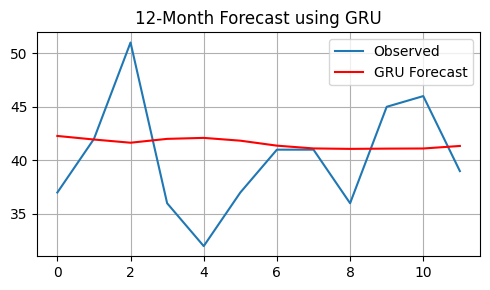

[[42.279724]
 [41.94645 ]
 [41.64778 ]
 [42.007904]
 [42.099197]
 [41.83875 ]
 [41.374023]
 [41.11433 ]
 [41.072918]
 [41.097347]
 [41.108887]
 [41.345745]]
GRU RMSE: 5.380429094236437
GRU MAE: 2.0883032709481246


In [ ]:
# GRU

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

data = monthly_total_accidents.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_data, window_size)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

results = model.predict(X_test)

predictions_inv = scaler.inverse_transform(results)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(5, 3))
plt.plot(y_test_inv, label='Observed')
plt.plot(predictions_inv, label='GRU Forecast', color='red')
plt.title('12-Month Forecast using GRU')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecast
print(predictions_inv)

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print("GRU RMSE:", rmse)
mae = np.sqrt(mean_absolute_error(y_test_inv, predictions_inv))
print("GRU MAE:", mae)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3050
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2288
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1710
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1299
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1035
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0895
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0847
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0858
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0902
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0954
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0997
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1020
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1018
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0995
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0954
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━

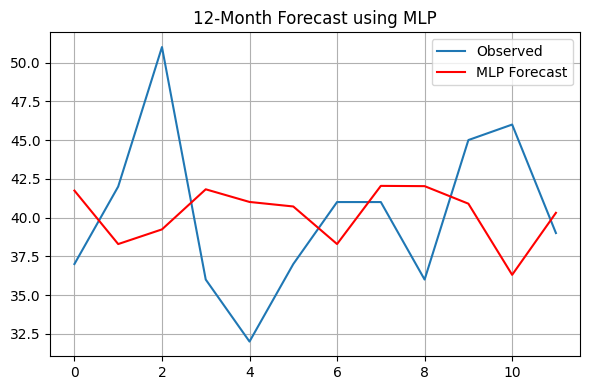

[[41.739017]
 [38.28941 ]
 [39.236332]
 [41.82286 ]
 [41.006798]
 [40.7146  ]
 [38.29123 ]
 [42.04381 ]
 [42.026634]
 [40.89572 ]
 [36.305096]
 [40.305237]]
MLP RMSE: 6.196263895002643
MLP MAE: 2.3029179045598682


In [ ]:
# MLP

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

data = monthly_total_accidents.values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_lagged_features(scaled_data, window_size)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(window_size, )))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=50, batch_size=3200, verbose=1)

results = model.predict(X_test)

predictions_inv = scaler.inverse_transform(results)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(6, 4))
plt.plot(y_test_inv, label='Observed')
plt.plot(predictions_inv, label='MLP Forecast', color='red')
plt.title('12-Month Forecast using MLP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecast
print(predictions_inv)

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print("MLP RMSE:", rmse)
mae = np.sqrt(mean_absolute_error(y_test_inv, predictions_inv))
print("MLP MAE:", mae)

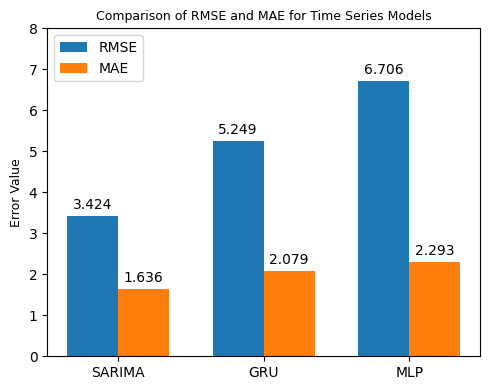

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract RMSE and MAE values from previous outputs
# Replace these with the actual values from your model outputs
sarima_rmse = 3.424290134219125
sarima_mae = 1.6363483062283082
gru_rmse = 5.2492742293255725
gru_mae = 2.0790355093135893
mlp_rmse = 6.7058837689368955
mlp_mae = 2.292998903456441

models = ['SARIMA', 'GRU', 'MLP']
rmse_values = [sarima_rmse, gru_rmse, mlp_rmse]
mae_values = [sarima_mae, gru_mae, mlp_mae]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(5, 4))
rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE')
rects2 = ax.bar(x + width/2, mae_values, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Error Value', fontsize=9) # Corrected typo here
ax.set_title('Comparison of RMSE and MAE for Time Series Models', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Set custom y-axis limits
ax.set_ylim(0, 8) # Example: setting y-axis limit from 0 to 8

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [ ]:
print(X_train.columns.tolist())


['Speed_Limit__km_h_', 'Driver_Age', 'State_Name_Arunachal_Pradesh', 'State_Name_Assam', 'State_Name_Bihar', 'State_Name_Chandigarh', 'State_Name_Chhattisgarh', 'State_Name_Delhi', 'State_Name_Goa', 'State_Name_Gujarat', 'State_Name_Haryana', 'State_Name_Himachal_Pradesh', 'State_Name_Jammu_and_Kashmir', 'State_Name_Jharkhand', 'State_Name_Karnataka', 'State_Name_Kerala', 'State_Name_Madhya_Pradesh', 'State_Name_Maharashtra', 'State_Name_Manipur', 'State_Name_Meghalaya', 'State_Name_Mizoram', 'State_Name_Nagaland', 'State_Name_Odisha', 'State_Name_Puducherry', 'State_Name_Punjab', 'State_Name_Rajasthan', 'State_Name_Sikkim', 'State_Name_Tamil_Nadu', 'State_Name_Telangana', 'State_Name_Tripura', 'State_Name_Uttar_Pradesh', 'State_Name_Uttarakhand', 'State_Name_West_Bengal', 'Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May', 'Month_November', 'Month_October', 'Month_September', 'Weather_Conditions___Clear____Clear_

[SKIP] Random Forest: No positive samples in y_test for class 3
[SKIP] Random Forest: No positive samples in y_test for class 4
[SKIP] Random Forest: No positive samples in y_test for class 5
[SKIP] Logistic Regression: No positive samples in y_test for class 3
[SKIP] Logistic Regression: No positive samples in y_test for class 4
[SKIP] Logistic Regression: No positive samples in y_test for class 5
[SKIP] SVM: No positive samples in y_test for class 3
[SKIP] SVM: No positive samples in y_test for class 4
[SKIP] SVM: No positive samples in y_test for class 5
[SKIP] XGBoost: No positive samples in y_test for class 3
[SKIP] XGBoost: No positive samples in y_test for class 4
[SKIP] XGBoost: No positive samples in y_test for class 5


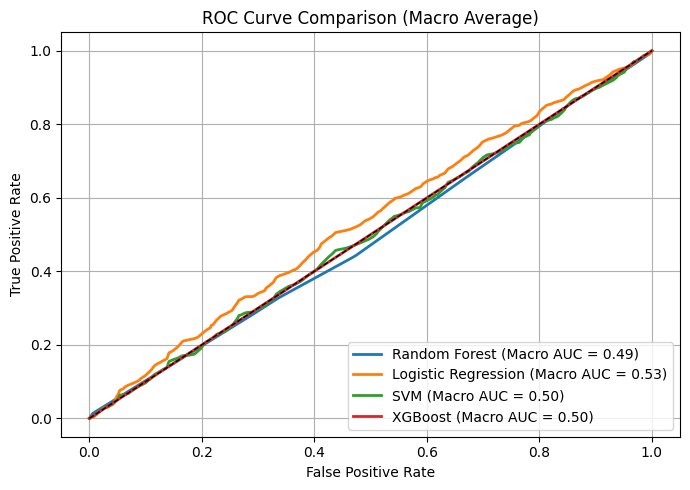


Macro and Micro AUC Scores:
                     Macro AUC  Micro AUC
Random Forest            0.490      0.562
Logistic Regression      0.534      0.559
SVM                      0.499      0.519
XGBoost                  0.500      0.345


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import pandas as pd

#  trained models
models = {
    "Random Forest": model_rf,
    "Logistic Regression": model_log,
    "SVM": model_svm,
    "XGBoost": model_xgb
}

# Force the full set of known classes
all_classes = [0, 1, 2, 3, 4, 5]

# Binarize y_test to always have 6 columns
y_test_bin = label_binarize(y_test, classes=all_classes)
n_classes = len(all_classes)

# Initialize plot
plt.figure(figsize=(7, 5))
roc_results = {}

for name, model in models.items():
    try:
        # Align test data columns
        model_features = model.feature_names_in_
        X_test_aligned = X_test.reindex(columns=model_features, fill_value=0)
    except AttributeError:
        print(f"[SKIP] {name}: Model has no .feature_names_in_")
        continue

    try:
        y_score = model.predict_proba(X_test_aligned)
    except Exception as e:
        print(f"[SKIP] {name}: predict_proba failed — {e}")
        continue

    if y_score.shape[1] != n_classes:
        print(f"[SKIP] {name}: Expected {n_classes} classes, got {y_score.shape[1]}")
        continue

    # ROC and AUC for each class (skip if class is missing in y_test)
    fpr, tpr, roc_auc = {}, {}, {}
    valid_classes = []

    for i in range(n_classes):
        if np.sum(y_test_bin[:, i]) == 0:
            print(f"[SKIP] {name}: No positive samples in y_test for class {i}")
            continue
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        valid_classes.append(i)

    # Macro-average (only over valid classes)
    if valid_classes:
        all_fpr = np.unique(np.concatenate([fpr[i] for i in valid_classes]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in valid_classes:
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(valid_classes)
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    else:
        roc_auc["macro"] = float("nan")

    # Micro-average
    try:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    except:
        roc_auc["micro"] = float("nan")

    # Plot macro-averaged ROC
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'{name} (Macro AUC = {roc_auc["macro"]:.2f})')

    # Store results
    roc_results[name] = {
        "Macro AUC": roc_auc["macro"],
        "Micro AUC": roc_auc["micro"]
    }

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Macro Average)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# AUC summary
print("\nMacro and Micro AUC Scores:")
print(pd.DataFrame(roc_results).T.round(3))


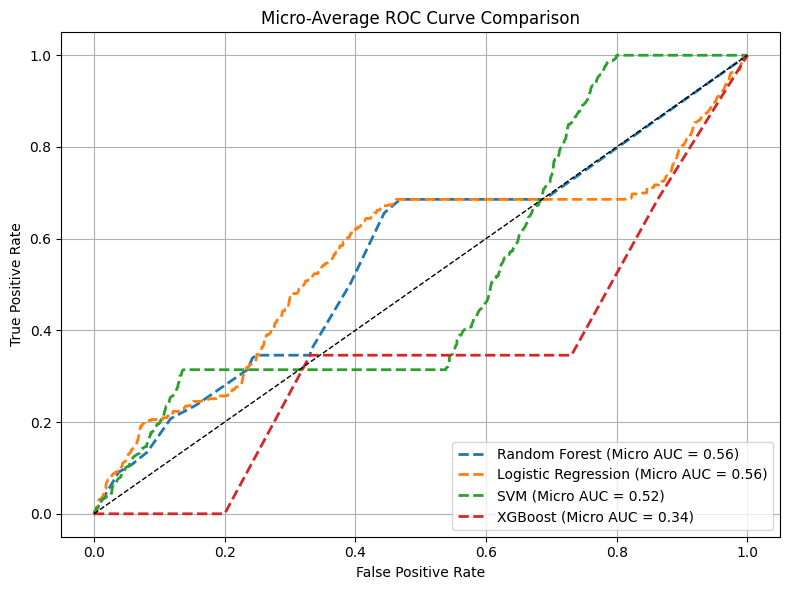

In [ ]:
plt.figure(figsize=(8, 6))

for name, model in models.items():
    try:
        # Align test set to model’s training features
        model_features = model.feature_names_in_
        X_test_aligned = X_test.reindex(columns=model_features, fill_value=0)

        # Get predicted probabilities
        y_score = model.predict_proba(X_test_aligned)

        # Compute micro-average ROC
        fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)

        plt.plot(fpr_micro, tpr_micro, linestyle='--', lw=2,
                 label=f'{name} (Micro AUC = {roc_auc_micro:.2f})')

    except Exception as e:
        print(f"[SKIP] {name}: {e}")

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Average ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('rf', model_rf),
        ('log', model_log),
        ('svm', model_svm),
        ('xgb', model_xgb)
    ],
    voting='soft'  # Use 'soft' if models support predict_proba
)
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)


Classification Report (Ensemble Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       106
           2       0.85      1.00      0.92        47
           3       0.78      0.78      0.78         9
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         1

    accuracy                           0.97       337
   macro avg       0.61      0.63      0.62       337
weighted avg       0.95      0.97      0.96       337



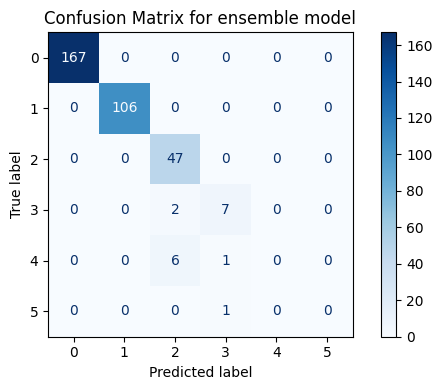

Accuracy       : 0.970
F1 Score (Macro): 0.617
Cohen’s Kappa  : 0.953


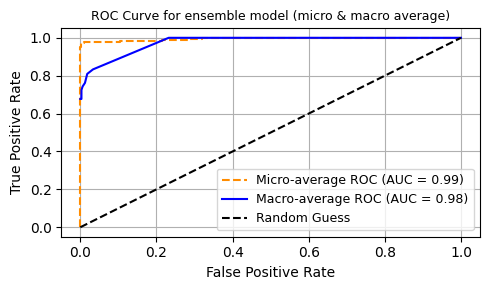

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# 1. Predict class labels
y_pred_ensemble = ensemble_model.predict(X_test)

# 2. Classification report
print("Classification Report (Ensemble Model):")
print(classification_report(y_test, y_pred_ensemble))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title("Confusion Matrix for ensemble model")
plt.grid(False)
plt.tight_layout()
plt.show()

# 4. Metrics: Accuracy, F1, Kappa
acc = accuracy_score(y_test, y_pred_ensemble)
f1 = f1_score(y_test, y_pred_ensemble, average='macro')
kappa = cohen_kappa_score(y_test, y_pred_ensemble)

print(f"Accuracy       : {acc:.3f}")
print(f"F1 Score (Macro): {f1:.3f}")
print(f"Cohen’s Kappa  : {kappa:.3f}")

# 5. ROC Curve (Micro & Macro AUC)
# Must binarize y_test for multiclass ROC
unique_classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=unique_classes)
n_classes = y_test_bin.shape[1]

# Get predicted probabilities for ROC
y_score_ensemble = ensemble_model.predict_proba(X_test)

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score_ensemble.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average ROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_ensemble[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute average TPR for macro
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr_macro = all_fpr
tpr_macro = mean_tpr
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Plot ROC curves
plt.figure(figsize=(5, 3))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', linestyle='--', color='darkorange')
plt.plot(fpr_macro, tpr_macro, label=f'Macro-average ROC (AUC = {roc_auc_macro:.2f})', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ensemble model (micro & macro average)', fontsize=9)
plt.legend(loc='lower right', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'combined_by_state_year_month.csv'


# Read the Excel file
data = pd.read_csv('combined_by_state_year_month.csv')

# Show the first 5 rows (with all columns)
print(data.head())  # This prints first 5 rows


       State Name  Year     Month  \
0  Andhra Pradesh  2018     April   
1  Andhra Pradesh  2018  December   
2  Andhra Pradesh  2018  February   
3  Andhra Pradesh  2018   January   
4  Andhra Pradesh  2018      June   

                                           timestamp  \
0                        ['2018-04-07 23:35:45.240']   
1  ['2018-12-01 06:43:26.400', '2018-12-04 15:57:...   
2  ['2018-02-02 15:25:08.040', '2018-02-06 17:52:...   
3                        ['2018-01-03 12:12:32.400']   
4  ['2018-06-04 16:43:31.800', '2018-06-04 17:24:...   

                           Day of Week                     Time _of _Day  \
0                         ['Saturday']                       ['23.5959']   
1  ['Saturday', 'Tuesday', 'Thursday']    ['6.724', '15.9593', '0.8081']   
2                ['Friday', 'Tuesday']            ['15.4189', '17.8753']   
3                        ['Wednesday']                        ['12.209']   
4    ['Monday', 'Monday', 'Wednesday']  ['16.7255', '17.4072